In [1]:
# imports
import Constants as c                           # constanst
import Functions as f                           # functions
import pandas as p                              # pandas
import numpy as np                              # numpy
import datetime as dt                           # datetime module for time intervals
from sklearn.cluster import DBSCAN              # DBSCAN algorithm
from sklearn.cluster import HDBSCAN             # HDBSCAN algorithm
import hdbscan as hdbs                          # improved (faster) HDBSCAN https://github.com/scikit-learn-contrib/hdbscan, https://joss.theoj.org/papers/10.21105/joss.00205
import matplotlib.pyplot as plt                 # plot
import gc                                       # garbage collector
from scipy.spatial import ConvexHull            # ConvexHulls for clusters
from shapely.geometry.polygon import Polygon    # for operations on clusters
import statistics as s                          # for statistics
import pickle                                   # for exporting the final result

# map plotting
import shapely as shpl               
import plotly.express as px
import plotly.offline as po
import plotly.graph_objects as go


Import source csv into a dataframe

In [2]:
FILE_NAME = '2019_01-05.csv'
clean_df = p.read_csv(c.FOLDER_PATH + FILE_NAME)
print(f'Dataframe shape: {clean_df.shape}')
print(clean_df.columns)
print(clean_df.shape)

Dataframe shape: (9528400, 17)
Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
       'VesselName', 'IMO', 'CallSign', 'VesselType', 'Status', 'Length',
       'Width', 'Draft', 'Cargo', 'TransceiverClass'],
      dtype='object')
(9528400, 17)


Columns dtypes optimization in order to reduce RAM usage <br>
(=casting to smaller dtypes)

In [3]:
optimized_df = p.DataFrame()

# MMSI - 9 digits number, converted from int64 to int32
optimized_df['MMSI'] = clean_df['MMSI'].astype('int32')

# BaseDateTime - from str to numpy.datetime64 (68 bytes -> 40 Bytes)
optimized_df['BaseDateTime'] = clean_df['BaseDateTime'].astype('datetime64[s]')

# LAT - No action. Just want to make sure to not loose precision 
optimized_df['LAT'] = clean_df['LAT']

# LON - No action. Just want to make sure to not loose precision 
optimized_df['LON'] = clean_df['LON']

# SOG - No action
optimized_df['SOG'] = clean_df['SOG']

# COG - No action
optimized_df['COG'] = clean_df['COG']

# Heading - No action
optimized_df['Heading'] = clean_df['Heading']

# VesselName - specify string dtype
optimized_df['VesselName'] = clean_df['VesselName'].astype(p.StringDtype())

# IMO - specify string dtype
optimized_df['IMO'] = clean_df['IMO'].astype(p.StringDtype())

# CallSign - specify string dtype
optimized_df['CallSign'] = clean_df['CallSign'].astype(p.StringDtype())

# VesselType - from float64 to int16. Following AIS specification, VesselType maximum value is around 1000
clean_df['VesselType'] = clean_df['VesselType'].fillna(value=0) # replaces all None values with zero.
optimized_df['VesselType'] = clean_df['VesselType'].astype('int16')

# Status - from float64 to int8. Following AIS specification, there are 16 (0-15) status codes
clean_df['Status'] = clean_df['Status'].fillna(value=99) # since 0 is a valid status code, 99 is used as a placeholder for None values
optimized_df['Status'] = clean_df['Status'].astype('int8')

# Length - from float64 to int16. Any floating point value is truncated to the closest integer.
# This is done on purpouse as an error of fractions of a meter is bearable.
clean_df['Length'] = clean_df['Length'].fillna(value=0)
optimized_df['Length'] = clean_df['Length'].astype('int16')

# Width - from float64 to int16. Any floating point value is truncated to the closest integer.
# This is done on purpouse as an error of fractions of a meter is bearable.
clean_df['Width'] = clean_df['Width'].fillna(value=0)
optimized_df['Width'] = clean_df['Width'].astype('int16')

# Draft - from float64 to float32
optimized_df['Draft'] = clean_df['Draft'].astype('float32')

# Cargo - from float64 to int16. Similar to VesselType
clean_df['Cargo'] = clean_df['Cargo'].fillna(value=0)
optimized_df['Cargo'] = clean_df['Cargo'].astype('int16')

# TransceiverClass - from string object to boolean. The new column ('IsClassA') holds True if the transceiver 
# is of type 'class A', false if it is of type 'class B'
optimized_df['IsClassA'] = clean_df['TransceiverClass'].map({'A':True, 'B':False})

# Round lat and lon values to 4 decimal digits (instead of 5)
optimized_df[['LAT','LON']] = optimized_df[['LAT','LON']].round(4)

print(clean_df.info())

print(optimized_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9528400 entries, 0 to 9528399
Data columns (total 17 columns):
 #   Column            Dtype  
---  ------            -----  
 0   MMSI              int64  
 1   BaseDateTime      object 
 2   LAT               float64
 3   LON               float64
 4   SOG               float64
 5   COG               float64
 6   Heading           float64
 7   VesselName        object 
 8   IMO               object 
 9   CallSign          object 
 10  VesselType        float64
 11  Status            float64
 12  Length            float64
 13  Width             float64
 14  Draft             float64
 15  Cargo             float64
 16  TransceiverClass  object 
dtypes: float64(11), int64(1), object(5)
memory usage: 1.2+ GB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9528400 entries, 0 to 9528399
Data columns (total 17 columns):
 #   Column        Dtype        
---  ------        -----        
 0   MMSI          int32        
 1   BaseDateTime 

Source: Pallotta, G., Vespe, M., & Bryan, K. (2013). Vessel Pattern Knowledge Discovery from AIS Data: A Framework for Anomaly Detection and Route Prediction. Entropy, 15(12), 2218–2245. https://doi.org/10.3390/e15062218

‌TREAD algorithm (pages 2223-2231)

In [4]:
def great_circle_distance_vectorized(lat_left, lon_left, lat_right, lon_right):
    '''Vectorized function used to calculate the Great-Circle distance between two GPS coordinates'''    
    lon_left, lat_left, lon_right, lat_right = map(np.radians, [lon_left, lat_left, lon_right, lat_right])
    deg_lon = lon_right - lon_left
    deg_lat = lat_right - lat_left
    a = np.sin(deg_lat/2.0)**2 + np.cos(lat_left) * np.cos(lat_right) * np.sin(deg_lon/2.0)**2
    cx = 2 * np.arcsin(np.sqrt(a))
    meters = c.EARTH_RADIUS_M * cx
    return meters

# From the complete db, select only the necessary columns
optimized_df = optimized_df[['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
                            'VesselName', 'VesselType', 'Status', 'Length',
                            'Width', 'Draft', 'IsClassA']].copy()
# Drop duplicates, just in case
optimized_df.drop_duplicates(subset=['MMSI', 'BaseDateTime'], keep='first', inplace=True, ignore_index=True)
optimized_df = optimized_df.sort_values(by='BaseDateTime')

reference_list_of_mmsi = p.unique(optimized_df['MMSI']).tolist()
reference_list_of_mmsi.sort()

V_s = [] # List of dataframes. Each dataframe represents a Vessel (and its journey)

# for each ship
for mmsi in reference_list_of_mmsi:
    # Extract all points generated by the ship
    appendDF = p.DataFrame(optimized_df[optimized_df['MMSI'] == mmsi])
    # Add a new column for storing the average speed between the current point and the previous
    appendDF['Avg_Speed'] = p.Series(dtype=p.Float64Dtype())
    # reset the index of the dataframe
    appendDF.reset_index(inplace=True)

    # next step: calculate the avg_speed (distance/time) in order to find stationary points. (SOG is not always reliable)
    # for the distance, the great-circle distance is used in order to account for earth curvature
    
    # save a shifted-by-one-row version of the db, so that "previous" points can be joined with "current" points
    shiftedDF = appendDF[['BaseDateTime','LAT', 'LON']].shift(1).copy()
    # the resulting df has (for each row) a pair of points. The left one is antecedent to the right one
    pairsOfPointsDF = shiftedDF.iloc[1:].join(appendDF[['BaseDateTime', 'LAT', 'LON', 'SOG']].iloc[1:], lsuffix='_left', rsuffix='_right')
    # calculate average speed for each row of the 'pairsOfPointsDF' df (each row represents a pair of points)
    # add a new column that holds the time difference between the two points of the row
    pairsOfPointsDF['DeltaTime'] = p.to_datetime(pairsOfPointsDF['BaseDateTime_right']) - p.to_datetime(pairsOfPointsDF['BaseDateTime_left'])
    # add a new column that holds the distance (in meters) between the two points of the same row
    pairsOfPointsDF['Distance'] = great_circle_distance_vectorized( pairsOfPointsDF['LAT_left'],
                                                                    pairsOfPointsDF['LON_left'],
                                                                    pairsOfPointsDF['LAT_right'],
                                                                    pairsOfPointsDF['LON_right']
                                                                    )
    # calculate average speed (in m/s)
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Distance'] / pairsOfPointsDF['DeltaTime'].dt.total_seconds()

    # sometimes a vessel can stop reporting its position and re-appear too far away from its last known location.
    # In this case it makes little sense to calculate the avg_speed. (np.nan multiplied by any number returns np.nan)
    
    # condition used to determine if the ship is "lost"
    lost_condition = (pairsOfPointsDF['DeltaTime'] > c.LOST_TIME_THRESHOLD_SECONDS)
    # another codition used to determine if the ship has left the domain for a significant amount of time
    exit_condition = (pairsOfPointsDF['DeltaTime'] > c.EXIT_TIME_THRESHOLD_HOURS)
    # the avg_speed of the points following the ones considered "lost" 
    # (which includes also vessels that satisfy the Exit condition) is set to nan
    pairsOfPointsDF.loc[lost_condition, 'Speed'] = np.nan
    # any nan point of the 'Speed' column is set to the corresponging 'SOG' value (if available and reliable)
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Speed'].fillna(
                                                                p.Series(
                                                                    np.where((  pairsOfPointsDF['SOG'] < c.ABSURD_SPEED_THRESHOLD), #if I have to rely on the SOG, check if it is plausible (verosimile)
                                                                                pairsOfPointsDF['SOG']/c.KNOTS_CONST, # if yes, use the SOG value (converted in m/s)
                                                                                pairsOfPointsDF['Distance'] / pairsOfPointsDF['DeltaTime'].dt.total_seconds() # if no, calculate it again
                                                                            )))
    
    # Add a new column for storing the status of the ship (according to TREAD algorithm, see above)
    pairsOfPointsDF['EstimatedStatus'] = p.Series(dtype=p.StringDtype())

    # set the status of the last and first points before (lost) and after (return) a small interruption
    pairsOfPointsDF.loc[lost_condition.shift(-1, fill_value=False), 'EstimatedStatus'] = 'lost'
    pairsOfPointsDF.loc[lost_condition, 'EstimatedStatus'] = 'return'
    # set the status of the last and first points before (exit) and after (entry) a big interruption
    pairsOfPointsDF.loc[exit_condition.shift(-1, fill_value=False), 'EstimatedStatus'] = 'exit'
    pairsOfPointsDF.loc[exit_condition, 'EstimatedStatus'] = 'entry'

    # convert the speed from meters to nautical knots
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Speed'] * c.KNOTS_CONST
    # round the final value to 2 decimal digits
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Speed'].round(decimals=2)
    
    # save the speed values to the ship df
    appendDF['Avg_Speed'] = pairsOfPointsDF['Speed'].copy()
    # The first row of each ship has its "Avg_Speed" field set equal to the SOG (due to lazyness this time the reliability of the SOG value is not checked)
    appendDF.at[appendDF.index[0], 'Avg_Speed'] = appendDF.at[appendDF.index[0], 'SOG']
    # Any row where avg_speed is set to np.nan is replaced with the SOG value
    appendDF.fillna({'Avg_Speed' : appendDF['SOG']}, inplace=True)    
    
    # Sometimes a vessel may broadcast an impossible GPS location. This is detected by looking for 
    # absurd values in the freshly calculated 'Avg_Speed' field. Any point that fits this description is then dropped.
    appendDF = appendDF[appendDF['Avg_Speed'] < c.ABSURD_SPEED_THRESHOLD]
    
    # Copy the estimated status column in the final ship df
    appendDF['EstimatedStatus'] = pairsOfPointsDF['EstimatedStatus'].copy()

    # drop the first column (generated during all the processing above)
    appendDF.drop('index', axis=1, inplace=True)
    # Rename the dataframe to the corresponding ship MMSI
    appendDF.name = str(mmsi)
    appendDF._metadata += ['name'] # this is necessary otherwise copying the dataframe will make it loose its name (why? ask Pandas, I don't know)
    # save the dataframe to the vessels list
    V_s.append(appendDF)

display(V_s[-1].head())

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,Length,Width,Draft,IsClassA,Avg_Speed,EstimatedStatus
0,983728088,2019-05-04 18:49:28,19.6333,-156.0027,0.6,250.0,511.0,<NA>,0,15,0,0,NaN,True,0.6,<NA>


In [5]:
# delete unused dataframe from RAM in order to save memory
# according to StackOverflow, this is the best way: 
# https://stackoverflow.com/questions/64368565/delete-and-release-memory-of-a-single-pandas-dataframe

del pairsOfPointsDF
del appendDF
del shiftedDF
del clean_df
gc.collect()

25

Next part of the TREAD algorithm</br>

Consider as stationary all points where the estimated average speed is lower then a set threshold</br>
Consider the first (entry) and last (exit) recorded points of each ship as 'stationary', regardless of the estimated speed.</br>
Set all remaing points as 'sailing'</br>

In [6]:
# for each vessel (dataframe) in the V_s list,
for index, shipDF in enumerate(V_s):
    # check that the ships are read in the same order
    if shipDF.name != str(reference_list_of_mmsi[index]):
        print('Error with ships order')

    # set the status of each point where the avg_speed is lower than the given threshold to 'stationary'
    shipDF['EstimatedStatus'] = np.where(((shipDF["Avg_Speed"] <= c.SPEED_THRESHOLD) &
                                         (shipDF['EstimatedStatus'].isnull())),
                                         'stationary', shipDF['EstimatedStatus'])
    # set all remaining null points as "sailing"
    shipDF['EstimatedStatus'] = np.where(((shipDF["Avg_Speed"] > c.SPEED_THRESHOLD) & 
                                         (shipDF['EstimatedStatus'].isnull())),
                                          'sailing', shipDF['EstimatedStatus'])
    # set the first and last points of each ship as "entry" and "exit" points respectively
    shipDF.loc[shipDF.index[0:1], 'EstimatedStatus'] = 'entry'
    shipDF.loc[shipDF.index[-1:], 'EstimatedStatus'] = 'exit'
    
    # sometimes a few consecutive points (for the same vessel) might be all with status 'entry' or 'exit'
    # this is unwanted and only one of those points is kept.
    # The rule is: keep the last of any consecutive 'entry' point and keep the first of any consecutive 'exit' point
    
    tempDF = shipDF[(shipDF['EstimatedStatus'] == 'entry') | (shipDF['EstimatedStatus'] == 'exit')] 

    condition_entry  = (
                        (tempDF['EstimatedStatus'] == 'entry') &
                        (tempDF['EstimatedStatus'].shift(-1) == tempDF['EstimatedStatus'])
                        )
    condition_exit =(
                        (tempDF['EstimatedStatus'] == 'exit') &
                        (tempDF['EstimatedStatus'].shift(1) == tempDF['EstimatedStatus'])
                    )
    # save the index of rows that need to be removed
    bad_entry_index = tempDF[condition_entry].index.to_list()
    bad_exit_index = tempDF[condition_exit].index.to_list()
    # if any of the above list is not empty
    if bad_entry_index or bad_exit_index:
        final_bad_index = bad_entry_index + bad_exit_index
        final_bad_index.sort()
        print(f'Removed duplicate entry or exit point at index {final_bad_index}.')
        print(f'Previous ship len: {shipDF.shape[0]}')
        shipDF = shipDF.drop(index=final_bad_index).reset_index()
        print(f'Current ship len: {shipDF.shape[0]}')
    # update the list of vessel with the updated values
    V_s[index] = shipDF

del shipDF
del tempDF
gc.collect()

Removed duplicate entry or exit point at index [2301].
Previous ship len: 3006
Current ship len: 3005
Removed duplicate entry or exit point at index [4001].
Previous ship len: 4002
Current ship len: 4001
Removed duplicate entry or exit point at index [133].
Previous ship len: 134
Current ship len: 133
Removed duplicate entry or exit point at index [0].
Previous ship len: 23
Current ship len: 22
Removed duplicate entry or exit point at index [0].
Previous ship len: 202
Current ship len: 201
Removed duplicate entry or exit point at index [3173].
Previous ship len: 3176
Current ship len: 3175
Removed duplicate entry or exit point at index [39816, 41454].
Previous ship len: 42183
Current ship len: 42181
Removed duplicate entry or exit point at index [1145].
Previous ship len: 1146
Current ship len: 1145
Removed duplicate entry or exit point at index [0].
Previous ship len: 35
Current ship len: 34
Removed duplicate entry or exit point at index [7180, 7181].
Previous ship len: 7790
Current s

0

,MMSI,BaseDateTime,SOG,Avg_Speed,EstimatedStatus
1600,9105773,2019-01-03 17:36:43,4.8,4.99,sailing
1601,9105773,2019-01-03 17:38:11,5.6,5.17,sailing
1602,9105773,2019-01-03 17:41:15,4.3,5.06,sailing
1603,9105773,2019-01-03 17:42:40,6.7,5.10,sailing
1604,9105773,2019-01-03 17:44:15,4.8,5.02,sailing
1605,9105773,2019-01-03 17:45:40,4.6,5.10,sailing
1606,9105773,2019-01-03 17:47:15,5.2,4.78,sailing
1607,9105773,2019-01-03 17:48:41,5.8,5.28,sailing
1608,9105773,2019-01-03 17:50:15,4.6,5.06,sailing
1609,9105773,2019-01-03 17:51:41,5.4,4.79,sailing


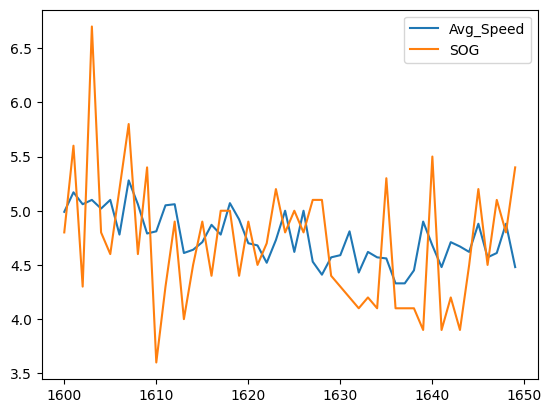

In [7]:
# print a dataframe and some points just to check the result
interval = range(1600,1650)
display(V_s[2].loc[interval, ['MMSI', 'BaseDateTime', 'SOG', 'Avg_Speed', 'EstimatedStatus']].head(10))
plt.plot(V_s[2].loc[interval,'Avg_Speed'])
plt.plot(V_s[2].loc[interval,'SOG'])
plt.legend(['Avg_Speed', 'SOG'])

In [8]:
# aggregate all the points back into a single dataframe
concatDF = p.concat(V_s, ignore_index=True).copy()

# Extract all the stationary points in a single dataframe
stationaryDF = p.DataFrame(columns=V_s[0].columns) # new empty df

# stationary points include all points that are useful for extracting routes
stationaryDF = concatDF[(concatDF['EstimatedStatus'] == 'stationary') |
                        (concatDF['EstimatedStatus'] == 'entry') |
                        (concatDF['EstimatedStatus'] == 'exit')
                        ].copy()

stationaryDF.reset_index(inplace=True)

print(f'{(stationaryDF.shape[0]/optimized_df.shape[0]) * 100: .2f}% of points are stationary!')

 68.76% of points are stationary!


In [9]:
# Some computationl tricks in order to save some time
print(f'Currently there are {stationaryDF.shape[0]} stationary points!')
# Group-by same (lat,lon) pairs and count occurrencies
groupedDF = stationaryDF.groupby(['LAT', 'LON']).size().reset_index(name='Weight')
print(f'The new df has {groupedDF.shape[0]} rows!')
print("Pair with most occurrencies: \n" + str(groupedDF.iloc[groupedDF['Weight'].idxmax(), :]) + '\n')

# Apply log2() (base-2 logarithm) to the 'weight' column in order to rescale its values
groupedDF['Weight'] = np.round(
                                np.log2(groupedDF['Weight']),
                                decimals=0
                            )
# The minimum weight should be 1, so any zero is arbitrarly replaced
groupedDF['Weight'] = groupedDF['Weight'].replace(0,1)

display(p.concat([groupedDF.head(5), groupedDF.tail(5)]))

print("Pair with most occurrencies: \n" + str(groupedDF.iloc[groupedDF['Weight'].idxmax(), :]) + '\n')

Currently there are 6550004 stationary points!
The new df has 87979 rows!
Pair with most occurrencies: 
LAT           21.2970
LON         -158.1065
Weight    113844.0000
Name: 60514, dtype: float64



,LAT,LON,Weight
0,18.7665,-155.7773,1.0
1,18.7666,-156.9702,1.0
2,18.7666,-156.9536,1.0
3,18.7667,-156.8071,1.0
4,18.7667,-155.8337,1.0
87974,22.6308,-156.8662,1.0
87975,22.6308,-156.6798,1.0
87976,22.6308,-156.0419,1.0
87977,22.6308,-155.5218,1.0
87978,22.6309,-158.3782,1.0


Pair with most occurrencies: 
LAT        21.2970
LON      -158.1065
Weight     17.0000
Name: 60514, dtype: float64



DBSCAN(eps=0.075, min_samples=10) len: 87979, num of clusters: 65


,LAT,LON,Weight,Label
0,18.7665,-155.7773,1.0,0
1,18.7666,-156.9702,1.0,-1
2,18.7666,-156.9536,1.0,-1
3,18.7667,-156.8071,1.0,-1
4,18.7667,-155.8337,1.0,0
87974,22.6308,-156.8662,1.0,61
87975,22.6308,-156.6798,1.0,61
87976,22.6308,-156.0419,1.0,61
87977,22.6308,-155.5218,1.0,63
87978,22.6309,-158.3782,1.0,64


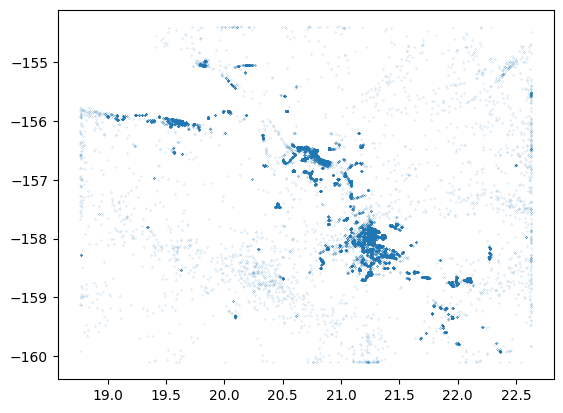

In [10]:
# Run DBSCAN algorithm on the grouped stationary points

# this scatter plot gives a rough idea of how the points should look like plotted on a map
plt.scatter(groupedDF.iloc[:,0], groupedDF.iloc[:,1], s=0.01)

# inizitalize dbscan object with parameters. TODO: test multiple parameters combinations
dbscan = DBSCAN(eps=0.075, min_samples=10)

estimator = dbscan.fit(
                       X=groupedDF.iloc[:, 0:2], 
                       sample_weight=groupedDF['Weight']
                      )

print(str(estimator) + " len: " + str(len(estimator.labels_)) + ", num of clusters: " + str(max(estimator.labels_)))

# Add labels to the dataframe
groupedDF['Label'] = estimator.labels_

display(p.concat([groupedDF.head(5), groupedDF.tail(5)]))

In [11]:
# plot the result of the DBSCAN clustering on a map (to have a look at the effects of the parameters)

clusteredPointsDF = groupedDF[groupedDF['Label'] != -1].copy()
outliersDF = groupedDF[groupedDF['Label'] == -1].copy()
clusteredPointsDF.reset_index(inplace=True)
outliersDF.reset_index(inplace=True)

display(p.concat([clusteredPointsDF.head(5), clusteredPointsDF.tail(5)]))

f.points_plotter(clustered=clusteredPointsDF,
               not_clustered=outliersDF,
               model=estimator)

,index,LAT,LON,Weight,Label
0,0,18.7665,-155.7773,1.0,0
1,4,18.7667,-155.8337,1.0,0
2,6,18.7668,-156.5645,1.0,1
3,7,18.7669,-156.6011,1.0,1
4,8,18.7669,-156.5696,1.0,1
86560,87974,22.6308,-156.8662,1.0,61
86561,87975,22.6308,-156.6798,1.0,61
86562,87976,22.6308,-156.0419,1.0,61
86563,87977,22.6308,-155.5218,1.0,63
86564,87978,22.6309,-158.3782,1.0,64


#### Hierarchical DBSCAN

Since the current sklearn hdbscan implementation does not allow to pass the weights of points as input,
the DataFrame that stores stationary points needs a little change: instead of passing the weights for each
coordinate, each line representing a coordinate is going to be duplicated for the same amount specified by its own weight

In [12]:
print(f'The new DF should have about {groupedDF.shape[0]} * {groupedDF["Weight"].mean(), 3} = {groupedDF.shape[0] * groupedDF["Weight"].mean()} rows.')

repeated_indices = np.repeat(groupedDF.index, groupedDF['Weight'])

h_groupedDF = groupedDF.loc[repeated_indices, ['LAT', 'LON']].reset_index(drop=True)

print('Rows of the new DF: {}'.format(h_groupedDF.shape[0]))

print(f'The new DF, if a "groupby" is applied again, should have the same number of rows of the original: {groupedDF.shape[0]} = {h_groupedDF.value_counts().shape[0]}')

The new DF should have about 87979 * (1.841553097898362, 3) = 162018.0 rows.
Rows of the new DF: 162018
The new DF, if a "groupby" is applied again, should have the same number of rows of the original: 87979 = 87979


In [13]:
# Run H-DBSCAN algorithm on the stationary points

# inizitalize h-dbscan object with parameters. TODO: test multiple parameters combinations
h_dbscan = hdbs.HDBSCAN(min_cluster_size=30,
                        cluster_selection_epsilon=0.01,
                        max_cluster_size=10_000)

h_labels = h_dbscan.fit_predict(
                    X=h_groupedDF.loc[:, ['LAT','LON']]
                    )

print(str(h_dbscan) + " len: " + str(len(h_labels)) + ", num of clusters: " + str(max(h_labels)))

# Add labels to the dataframe
h_groupedDF['Label'] = h_labels

display(h_groupedDF)
#print(groupedDF['Label'].max())

HDBSCAN(cluster_selection_epsilon=0.01, max_cluster_size=10000,
        min_cluster_size=30) len: 162018, num of clusters: 211


,LAT,LON,Label
0,18.7665,-155.7773,-1
1,18.7666,-156.9702,-1
2,18.7666,-156.9536,-1
3,18.7667,-156.8071,-1
4,18.7667,-155.8337,-1
...,...,...,...
162013,22.6308,-156.8662,3
162014,22.6308,-156.6798,3
162015,22.6308,-156.0419,3
162016,22.6308,-155.5218,5


In [14]:
# Show the result of h-dbscan on a map

clusteredPointsDF = h_groupedDF[(h_groupedDF['Label'] != -1)].copy()
outliersDF = h_groupedDF[h_groupedDF['Label'] == -1].copy()

clusteredPointsDF = clusteredPointsDF.groupby(by=['LAT', 'LON', 'Label']).size().reset_index(name='Weight')

# plot points and clusters
f.points_plotter(clustered=clusteredPointsDF,
               not_clustered=outliersDF,
               model=h_dbscan)

Plot a heatmap using all the points, even the non-stationary ones

In [15]:
%%script false --no-raise-error
# the code above is used to prevent the Python kernel from running this cell (https://stackoverflow.com/a/56247673/24805169)

concatDF[['LAT','LON']] = concatDF[['LAT','LON']].round(3)

heatmapDF = concatDF.groupby(['LAT','LON']).size().reset_index(name='Weight')

# Apply log2() (base-2 logarithm) to the 'weight' column in order to rescale its values
heatmapDF['Weight'] = np.round(
                                np.log2(heatmapDF['Weight']),
                                decimals=0
                            )
# The minimum weight should be 1, so any zero is replaced
#heatmapDF['Weight'].replace(0,1,inplace=True)

print("Pair with most occurrencies: \n" + str(heatmapDF.iloc[heatmapDF['Weight'].idxmax(), :]) + '\n')
print(concatDF.shape)
print(heatmapDF.shape)


In [16]:
%%script false --no-raise-error
# the code above is used to prevent the Python kernel from running this cell (https://stackoverflow.com/a/56247673/24805169)

fig2 = px.density_mapbox(
    data_frame=heatmapDF,
    lat='LAT',
    lon='LON',
    z='Weight',
    radius=5,
    zoom=6,
    mapbox_style='open-street-map'
)
fig2.update_layout(mapbox_style = 'open-street-map',
                    margin={'r':0, 't':40, 'l':0, 'b':0}
                    )
                    
po.plot(fig2)


### Waypoints and Routes identification</br>

##### Waypoints


In [17]:
num_of_wp = h_groupedDF['Label'].max()

# Creation of a df for storing the Waypoints
waypointsDF = p.DataFrame()
waypointsDF['Name'] = ['WP_' + str(i) for i in range(0, num_of_wp+1)] # every WP is named 'WP_X', where X is a integer value
waypointsDF['ConvexHullObj'] = p.Series()  # empty column
waypointsDF['VerticesIndex'] = p.Series() # empty column
waypointsDF['LAT'] = p.Series() # empty column
waypointsDF['LON'] = p.Series() # empty column
waypointsDF['Coords'] = p.Series() # empty column
waypointsDF['PolygonObj'] = p.Series() # empty column
# Exclude non-clustered (noise) points (labeled as -1)
onlyClusteredPointsDF = h_groupedDF[h_groupedDF['Label'] != -1].copy()


for wp_label in onlyClusteredPointsDF['Label'].unique():
    # create convex hull object using all points with label = wp_label (concave hulls/ alpha shapes could be an alternative but they require an additional parameter))
    groupLATLONDF = onlyClusteredPointsDF[onlyClusteredPointsDF['Label']==wp_label][['LAT', 'LON']]
    conv_hull = ConvexHull(groupLATLONDF)
    # store the ConvexHull object in the dataframe
    waypointsDF.loc[wp_label, 'ConvexHullObj'] = conv_hull
    # and also store the vertices of the ConvexHull (waypoint)
    waypointsDF.at[wp_label, 'VerticesIndex'] = conv_hull.vertices
    
    # this list comprehension creates a list of series
    hull_lon = [groupLATLONDF['LON'].reset_index().iloc[vertex_idx] for vertex_idx in conv_hull.vertices]
    hull_lat = [groupLATLONDF['LAT'].reset_index().iloc[vertex_idx] for vertex_idx in conv_hull.vertices]
    
    #from the list of series extract the second value of each serie (after converting the serie to list)
    hull_lon = [serie.tolist()[1] for serie in hull_lon]
    hull_lat = [serie.tolist()[1] for serie in hull_lat]

    # save the LAT and LON values to the appropriate row and column
    waypointsDF.at[wp_label, 'LAT'] = hull_lat
    waypointsDF.at[wp_label, 'LON'] = hull_lon

    # zip the LAT and LON values of each row together in a new column (this is needed in order to create a Polygon)
    waypointsDF.at[wp_label, 'Coords'] = list(zip(hull_lon, hull_lat))
    waypointsDF.at[wp_label, 'Coords'].append((hull_lon[0], hull_lat[0]))

    # create a Polygon
    waypointsDF.at[wp_label, 'PolygonObj'] = Polygon(waypointsDF.at[wp_label, 'Coords'])


display(waypointsDF.head())

,Name,ConvexHullObj,VerticesIndex,LAT,LON,Coords,PolygonObj
0,WP_0,<scipy.spatial._qhull.ConvexHull object at 0x7...,"[100, 97, 19, 3, 0, 1, 55, 98, 99]","[22.6304, 22.4685, 22.3336, 22.1721, 22.1326, ...","[-159.8241, -159.7035, -159.7745, -159.92, -15...","[(-159.8241, 22.6304), (-159.7035, 22.4685), (...","POLYGON ((-159.8241 22.6304, -159.7035 22.4685..."
1,WP_1,<scipy.spatial._qhull.ConvexHull object at 0x7...,"[26, 30, 29, 24, 14, 6, 4, 0, 1]","[20.1582, 20.2334, 20.2105, 20.1443, 20.079, 2...","[-154.5182, -154.4575, -154.3921, -154.3896, -...","[(-154.5182, 20.1582), (-154.4575, 20.2334), (...","POLYGON ((-154.5182 20.1582, -154.4575 20.2334..."
2,WP_2,<scipy.spatial._qhull.ConvexHull object at 0x7...,"[1, 0, 2, 4, 141, 143, 144, 142, 123]","[19.4427, 19.4174, 19.4469, 19.4913, 19.6974, ...","[-156.3153, -156.4096, -156.4756, -156.5183, -...","[(-156.3153, 19.4427), (-156.4096, 19.4174), (...","POLYGON ((-156.3153 19.4427, -156.4096 19.4174..."
3,WP_3,<scipy.spatial._qhull.ConvexHull object at 0x7...,"[140, 15, 6, 0, 1, 5, 7, 69, 156, 158, 160, 150]","[22.6296, 22.448, 22.3758, 22.3251, 22.3427, 2...","[-155.9447, -155.7694, -156.0404, -156.7519, -...","[(-155.9447, 22.6296), (-155.7694, 22.448), (-...","POLYGON ((-155.9447 22.6296, -155.7694 22.448,..."
4,WP_4,<scipy.spatial._qhull.ConvexHull object at 0x7...,"[87, 86, 62, 4, 2, 1, 0, 5]","[22.6028, 22.5904, 22.463, 22.2967, 22.2325, 2...","[-155.3505, -154.9036, -154.8877, -155.0003, -...","[(-155.3505, 22.6028), (-154.9036, 22.5904), (...","POLYGON ((-155.3505 22.6028, -154.9036 22.5904..."


<Axes: >

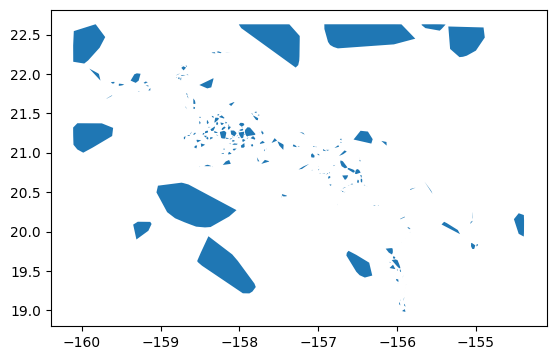

In [18]:
# quick plot the extracted polygons to check if everything worked fine
import geopandas
quick_plot = geopandas.GeoSeries(waypointsDF['PolygonObj'])
quick_plot.plot()

##### Routes identification

In [19]:
# for each LAT, LON pair, create a shapely.Point
concatDF['PointsObj'] = [shpl.Point(x,y) for (x,y) in concatDF[['LON', 'LAT']].values] #apparently this is faster than usig pandas.Dataframe.apply()

# for each WP, for each row of the entire dataset, check if the point is inside any WP
for name, polygon_obj in  waypointsDF[['Name', 'PolygonObj']].values:
    concatDF[str(name)] = polygon_obj.contains(concatDF['PointsObj']) # for each wp, create a new column containing either True or False

# list of column names just created
list_of_columns = [name for name in waypointsDF['Name']]

#idxmax: for each row, return the id (name) of the column containing the first occurrence of the maximum value. There are only bool values so True = 1 > False = 0
# basically returns the name of the WP where the point is contained. If the row has only 'False' values, it returns the first column (this is fixed below)
# this works under the assumption that any given point can belong to either zero or one WP.
concatDF['IsInWP'] = concatDF[list_of_columns].idxmax(axis=1)

# find all rows that have only 'False' values. The '~' negates the values (its like applying the binary NOT)
all_false_rows = concatDF[(~concatDF[list_of_columns]).all(axis=1)].index
# Replace the value in the 'IsInWP' column as 'None'
concatDF.loc[all_false_rows, 'IsInWP'] = None
# drop unnecessary columns
concatDF.drop(list_of_columns, axis=1, inplace=True)
concatDF.drop(['index', 'PointsObj'], axis=1, inplace=True)

display(concatDF.head(10))

/tmp/ipykernel_10056/3323970853.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_10056/3323970853.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_10056/3323970853.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_10056/3323970853.py:6: Performance

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,Length,Width,Draft,IsClassA,Avg_Speed,EstimatedStatus,IsInWP
0,0,2019-05-17 15:48:51,20.0183,-155.0548,14.3,172.2,171.0,<NA>,170,0,20,6,11.5,True,14.30,exit,None
1,382872,2019-01-08 19:32:26,21.3557,-157.9487,5.1,308.0,511.0,HARRIER,0,15,20,5,0.0,True,5.10,entry,WP_207
2,382872,2019-01-08 19:33:37,21.3569,-157.9501,5.2,316.5,511.0,HARRIER,0,15,20,5,0.0,True,5.40,sailing,WP_207
3,382872,2019-01-08 19:34:47,21.3580,-157.9514,5.2,300.0,511.0,HARRIER,0,15,20,5,0.0,True,5.06,sailing,WP_207
4,382872,2019-01-08 19:35:57,21.3584,-157.9532,5.2,274.0,511.0,HARRIER,0,15,20,5,0.0,True,5.33,sailing,WP_207
5,382872,2019-01-08 19:37:07,21.3578,-157.9548,5.1,232.0,511.0,HARRIER,0,15,20,5,0.0,True,4.97,sailing,WP_207
6,382872,2019-01-08 19:38:24,21.3571,-157.9565,5.2,247.7,511.0,HARRIER,0,15,20,5,0.0,True,4.86,sailing,WP_207
7,382872,2019-01-08 19:39:42,21.3563,-157.9584,5.2,242.2,511.0,HARRIER,0,15,20,5,0.0,True,5.39,sailing,WP_207
8,382872,2019-01-08 19:41:03,21.3555,-157.9603,5.2,246.0,511.0,HARRIER,0,15,20,5,0.0,True,5.19,sailing,WP_207
9,382872,2019-01-08 19:42:13,21.3550,-157.9621,5.2,258.4,511.0,HARRIER,0,15,20,5,0.0,True,5.41,sailing,WP_207


IsInWP
WP_211    4983386
None      2078580
WP_170     642143
WP_207     511929
WP_190     153154
           ...   
WP_151         57
WP_42          48
WP_194         41
WP_119         40
WP_17          37
Name: count, Length: 213, dtype: int64
(9525688, 17)


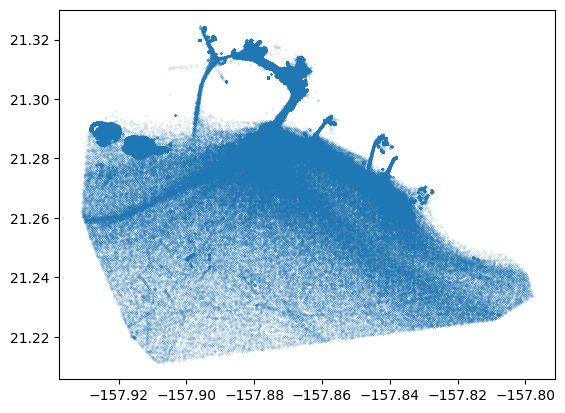

In [20]:
# count the number of points contained in each WP. 
# 'WP_X' -> the point is generated inside WP_X
# None -> the point does not belong to any cluster
value_counts = concatDF['IsInWP'].value_counts(dropna=False)
print(value_counts)
print(concatDF.shape)
# quick plot of the WP with the highest amount of points
testDF = concatDF[concatDF['IsInWP'] == value_counts.index[0]]
plt.scatter(testDF['LON'], testDF['LAT'], s=0.01)

#### Routes extraction
For each vessel contained in V_s (used at the beginning of this notebook), create a new column (called 'Route') specifying the current route.</br>If the ship is inside a WP, than the WP name is used in the new column.</br>If the ship is at open sea ('IsInWP' == None) then the Route column is filled in the following way:
* let A and B be the names of the start and end WPs, respectively. In order for them to be considered, they need to be either 'entry' or 'exit' WPs, or the vessel needs to generate at least one stationary point inside them
* if both A and B are known, the route name is built as A - B
* if either one is missing (pd.NA), the route name is built as "\<NA> - B" or "A - \<NA>"

In [ ]:
concatDF['IsInSignificantWP'] = p.Series(dtype=p.StringDtype())
concatDF['Route'] = p.Series(dtype=p.StringDtype())
print(concatDF.shape)
for index, unique_mmsi in enumerate(reference_list_of_mmsi):
    vesselDF = concatDF[concatDF['MMSI'] == unique_mmsi].copy().reset_index(drop=True)
    vesselDF['IsInSignificantWP'] = p.Series(dtype=p.StringDtype()) # new empty column
    vesselDF['PreviousWP'] = p.Series(dtype=p.StringDtype())
    vesselDF['NextWP'] = p.Series(dtype=p.StringDtype())
    # extract the indeces of any entry-exit pair of points
    entry_points_index = vesselDF[vesselDF['EstimatedStatus'] == 'entry'].index.to_list()
    exit_points_index = vesselDF[vesselDF['EstimatedStatus'] == 'exit'].index.to_list()
    entry_exit_pairs_list = list(zip(entry_points_index, exit_points_index))
    # check formal validity of entry/exit pairs
    for idx, pair in enumerate(entry_exit_pairs_list):
        entry_idx, exit_idx = pair[0], pair[1]
        sub_range = range(entry_idx, exit_idx+1)            
        next_item = entry_exit_pairs_list[(idx + 1) % len(entry_exit_pairs_list)]
        if ((exit_idx + 1) != next_item[0]) and (idx+1 != len(entry_exit_pairs_list)):
            print(f'Error for tuples {pair}, {next_item} for vessel {unique_mmsi} with index {index}')
            break
        # if the pair is valid, extract the routes

        # create a new column for storing when a point is in a WP with a Avg_Speed lower than the threshold used for stationary points
        significantWP_condition = ( (vesselDF.loc[sub_range, 'Avg_Speed'] <= c.SPEED_THRESHOLD)
                                    | (vesselDF.loc[sub_range, 'EstimatedStatus'] == 'entry')
                                    | (vesselDF.loc[sub_range, 'EstimatedStatus'] == 'exit') 
                                   )

        vesselDF.loc[sub_range, 'IsInSignificantWP'] = np.where(significantWP_condition, vesselDF.loc[sub_range, 'IsInWP'], None)
  
        # create a new column where each row contains the name of the previous WP
        vesselDF.loc[sub_range, 'PreviousWP'] = vesselDF.loc[sub_range, 'IsInSignificantWP'].ffill()
        
        # create a new column where each row contains the name of the following WP
        vesselDF.loc[sub_range, 'NextWP'] = vesselDF.loc[sub_range, 'IsInSignificantWP'].bfill()
    
        #replace None values with pandas.NA, which is like np.NaN but for non-numeric values
        vesselDF.loc[sub_range, 'PreviousWP'] = vesselDF.loc[sub_range, 'PreviousWP'].fillna(p.NA)
        vesselDF.loc[sub_range, 'NextWP'] = vesselDF.loc[sub_range, 'NextWP'].fillna(p.NA)
        
        # create the route name as 'A - B'
        vesselDF.loc[sub_range, 'Route'] = vesselDF.loc[sub_range, 'IsInSignificantWP'].combine_first(vesselDF.loc[sub_range, 'PreviousWP'].astype(str) + ' - ' + vesselDF.loc[sub_range, 'NextWP'].astype(str))

    # remove auxiliary columns that aren't necessary anymore
    vesselDF.drop(['PreviousWP', 'NextWP'], axis=1, inplace=True)
    #save df to the list of vessels (V_s)
    V_s[index] = vesselDF.copy()

concatDF = p.concat(V_s).copy()
#print(V_s[200][['BaseDateTime', 'MMSI', 'LAT', 'LON', 'EstimatedStatus', 'Avg_Speed', 'IsInWP','IsInSignificantWP', 'Route']].to_string())
display(V_s[0].loc[0:100])

##### Plot ship path on a map

In [29]:
# dataframe structure should be the same of "concatDF"
to_be_plotted = V_s[5]
f.plot_routes(to_be_plotted, clusteredPointsDF, "SingleVessel")

#### Search for the most popular routes

In [30]:
def count_groups(df, col_name):
    df['shifted'] = df[col_name].shift(1)
    df['change'] = df[col_name] != df['shifted']
    df['group'] = df['change'].cumsum()
    group_counts = df.groupby('group')[col_name].first().value_counts()
    return group_counts

result = {}

for temp_vessel in V_s:
    group_counts = count_groups(temp_vessel, 'Route')
    for key, count in group_counts.items():
        if key not in result.keys():
            result[key] = count
        else:
            result[key] += count

tempDF = p.DataFrame(data={'Name': result.keys(), 'Count': result.values()}).sort_values(by='Count', ascending=False).to_string()
print(tempDF)

                 Name  Count
4              WP_211  31570
5     WP_211 - WP_211  29258
0              WP_207  14899
1     WP_207 - WP_207  14614
1064           WP_161   5562
1065  WP_161 - WP_161   5561
65             WP_164   4173
107            WP_170   3712
125            WP_190   3671
95    WP_164 - WP_164   3520
126   WP_190 - WP_190   3415
122   WP_170 - WP_170   3162
113             WP_44   2762
149     WP_44 - WP_44   2549
133             WP_70   2106
152     WP_70 - WP_70   1816
64              WP_30   1651
129     WP_30 - WP_30   1403
47              WP_55    906
48      WP_55 - WP_55    720
54             WP_118    657
10      <NA> - WP_211    631
8       WP_211 - <NA>    617
72             WP_138    598
81             WP_121    551
815            WP_148    535
401   WP_118 - WP_164    507
69    WP_164 - WP_118    494
433            WP_180    442
434   WP_180 - WP_180    437
816   WP_148 - WP_148    375
560             WP_78    369
423   WP_138 - WP_138    363
561     WP_78 

In [43]:
display(concatDF[concatDF['Route'].isnull()])
concatDF = concatDF[concatDF['Route'].notna()]
display(concatDF[concatDF['Route'].isnull()])

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,Length,Width,Draft,IsClassA,Avg_Speed,EstimatedStatus,IsInWP,IsInSignificantWP,Route,IsInRoute
0,0,2019-05-17 15:48:51,20.0183,-155.0548,14.3,172.2,171.0,<NA>,170,0,20,6,11.5,True,14.30,exit,None,<NA>,<NA>,<NA>
0,182083130,2019-02-28 09:28:52,22.5822,-155.6414,55.8,31.9,490.0,<NA>,0,99,0,0,NaN,False,55.80,exit,None,<NA>,<NA>,<NA>
0,189750956,2019-01-25 08:13:49,20.6338,-155.6523,56.7,299.9,37.0,<NA>,0,99,0,0,NaN,False,56.70,exit,None,<NA>,<NA>,<NA>
0,303673004,2019-05-19 13:19:44,21.0113,-156.7954,8.8,67.7,70.0,<NA>,0,4,0,0,NaN,True,8.80,exit,None,<NA>,<NA>,<NA>
0,303999001,2019-05-07 16:21:58,21.2726,-157.7874,77.9,339.5,320.0,SETTE LAUNCH,90,8,0,0,NaN,True,77.90,exit,None,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,983104655,2019-04-25 00:41:30,20.8642,-156.6855,5.6,199.0,511.0,T14,60,99,0,0,NaN,False,5.59,sailing,WP_164,<NA>,<NA>,<NA>
88,983104655,2019-04-25 00:43:00,20.8620,-156.6864,5.3,204.0,511.0,T14,60,99,0,0,NaN,False,5.66,sailing,WP_164,<NA>,<NA>,<NA>
89,983104655,2019-04-25 00:44:31,20.8598,-156.6869,5.6,185.8,511.0,T14,60,99,0,0,NaN,False,5.35,sailing,WP_164,<NA>,<NA>,<NA>
90,983104655,2019-04-25 00:46:03,20.8581,-156.6863,5.6,113.3,511.0,T14,60,99,0,0,NaN,False,4.21,sailing,WP_164,<NA>,<NA>,<NA>


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,Length,Width,Draft,IsClassA,Avg_Speed,EstimatedStatus,IsInWP,IsInSignificantWP,Route,IsInRoute


In [45]:
concatDF['IsInRoute'] = concatDF['Route'].str.contains('-')

# plot all points given a certain route
# ----- Specify route name here --------
route_name = 'WP_118' + ' - ' + 'WP_164'
chosen_points = concatDF[concatDF['Route'] == route_name].copy()
f.plot_routes(chosen_points, clusteredPointsDF, mode='SingleRoute')

# create a list of Dataframes (each representing a single route)
concatDF['group'] = concatDF['group'] = (concatDF['IsInRoute'] & (~concatDF['IsInRoute'].shift(1, fill_value=False))).astype(int)
concatDF['route_id'] = concatDF['group'].cumsum()
only_route_points = concatDF[(concatDF['IsInRoute'] == True) & (concatDF['Route'] == route_name)]
list_of_routes = [route for _, route in only_route_points.groupby('route_id')]
concatDF.drop('group', axis=1)
# check the list of routes before exporting it
lengths = [len(x) for x in list_of_routes]
print(f"mean: {s.mean(lengths)}, median: {s.median(lengths)}, min: {min(lengths)}, max: {max(lengths)}: routes: {len(lengths)}, moda: {s.mode(lengths)}")

mean: 36.510848126232744, median: 34, min: 13, max: 149: routes: 507, moda: 36


In [46]:
display(list_of_routes[2].head(5))
display(list_of_routes[2].tail(5))
display(concatDF.head(5))

# Save the result to a binary pickle file so that it can be imported by the next ipynb
with open('../out/TREAD_out.pkl', 'wb') as file:
    pickle.dump((concatDF, list_of_routes, route_name), file)

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,...,Draft,IsClassA,Avg_Speed,EstimatedStatus,IsInWP,IsInSignificantWP,Route,IsInRoute,group,route_id
8506,338242587,2019-05-20 19:53:30,20.7426,-156.8862,3.5,128.7,132.0,NOHO ANA,36,99,...,NaN,False,1.71,sailing,WP_118,<NA>,WP_118 - WP_164,True,1,7351
8507,338242587,2019-05-20 19:54:31,20.7419,-156.8854,3.6,137.7,137.0,NOHO ANA,36,99,...,NaN,False,3.63,sailing,WP_118,<NA>,WP_118 - WP_164,True,0,7351
8508,338242587,2019-05-20 19:56:00,20.7408,-156.8841,3.4,134.0,137.0,NOHO ANA,36,99,...,NaN,False,3.99,sailing,WP_118,<NA>,WP_118 - WP_164,True,0,7351
8509,338242587,2019-05-20 19:57:31,20.7398,-156.8828,3.8,131.9,138.0,NOHO ANA,36,99,...,NaN,False,3.74,sailing,WP_118,<NA>,WP_118 - WP_164,True,0,7351
8510,338242587,2019-05-20 19:59:01,20.7388,-156.8815,3.5,126.9,140.0,NOHO ANA,36,99,...,NaN,False,3.78,sailing,WP_118,<NA>,WP_118 - WP_164,True,0,7351


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,...,Draft,IsClassA,Avg_Speed,EstimatedStatus,IsInWP,IsInSignificantWP,Route,IsInRoute,group,route_id
8633,338242587,2019-05-20 22:59:31,20.8705,-156.7090,5.3,47.8,52.0,NOHO ANA,36,99,...,NaN,False,4.92,sailing,WP_164,<NA>,WP_118 - WP_164,True,0,7351
8634,338242587,2019-05-20 23:00:01,20.8710,-156.7085,5.3,51.6,52.0,NOHO ANA,36,99,...,NaN,False,4.94,sailing,WP_164,<NA>,WP_118 - WP_164,True,0,7351
8635,338242587,2019-05-20 23:01:33,20.8725,-156.7069,4.9,45.1,52.0,NOHO ANA,36,99,...,NaN,False,4.98,sailing,WP_164,<NA>,WP_118 - WP_164,True,0,7351
8636,338242587,2019-05-20 23:03:02,20.8740,-156.7054,5.2,42.4,53.0,NOHO ANA,36,99,...,NaN,False,4.99,lost,WP_164,<NA>,WP_118 - WP_164,True,0,7351
8637,338242587,2019-05-20 23:19:03,20.8884,-156.6908,4.0,47.5,45.0,NOHO ANA,36,99,...,NaN,False,1.00,return,WP_164,<NA>,WP_118 - WP_164,True,0,7351


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,...,Draft,IsClassA,Avg_Speed,EstimatedStatus,IsInWP,IsInSignificantWP,Route,IsInRoute,group,route_id
0,382872,2019-01-08 19:32:26,21.3557,-157.9487,5.1,308.0,511.0,HARRIER,0,15,...,0.0,True,5.10,entry,WP_207,WP_207,WP_207,False,0,0
1,382872,2019-01-08 19:33:37,21.3569,-157.9501,5.2,316.5,511.0,HARRIER,0,15,...,0.0,True,5.40,sailing,WP_207,<NA>,WP_207 - WP_207,True,1,1
2,382872,2019-01-08 19:34:47,21.3580,-157.9514,5.2,300.0,511.0,HARRIER,0,15,...,0.0,True,5.06,sailing,WP_207,<NA>,WP_207 - WP_207,True,0,1
3,382872,2019-01-08 19:35:57,21.3584,-157.9532,5.2,274.0,511.0,HARRIER,0,15,...,0.0,True,5.33,sailing,WP_207,<NA>,WP_207 - WP_207,True,0,1
4,382872,2019-01-08 19:37:07,21.3578,-157.9548,5.1,232.0,511.0,HARRIER,0,15,...,0.0,True,4.97,sailing,WP_207,<NA>,WP_207 - WP_207,True,0,1
